# Imports and Reads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import pingouin as pg

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
df = pd.read_csv("data.csv")
df.drop(["Latitude", "Longitude", "Geo County"], inplace=True, axis=1)
df.head()

,Taxable Year,County,Population,All Returns,AGI,Median Income,Median Rank,Joint Returns,Joint Returns Median Income,Joint Returns Median Rank,Tax Assessed
0,2011,Plumas,19953.0,7234,326683000,33509,28.0,3584,54112,36.0,8800000
1,2009,Nonresident,0.0,502103,180161996000,59342,0.0,268250,108722,0.0,1387232000
2,2007,Modoc,9659.0,3069,118770000,28083,52.0,1545,44018,56.0,3666000
3,2005,Nonresident,0.0,522584,138452361000,58612,0.0,281732,98575,0.0,1773706000
4,2003,Nonresident,0.0,436493,129987919000,54532,0.0,234008,91267,0.0,1068795000


# Pre-processing

In [3]:
unique_years = np.sort(df["Taxable Year"].unique())
unique_counties = df["County"].unique()

In [4]:
counties_years_df = pd.DataFrame(index=unique_counties, columns=unique_years)
for year in unique_years:
    for county in unique_counties:
        current_query = df.loc[(df["Taxable Year"] == year) & (df["County"] == county), "Median Income"]
        if current_query.shape[0] > 0:
            current_median = current_query.values[0]
            counties_years_df.loc[county, year] = current_median

counties_years_df.head()

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Plumas,22217,23643,26151,26196,27913,29612,29717,29872,30306,31353,...,34484,35679,35966,34590,35751,37791,38411,38241,37225,41837
Nonresident,38300,45830,49514,53026,55563,57766,54721,54467,54532,56182,...,70160,69875,71228,71107,NaN,14600,16109,19434,22021,26804
Modoc,19401,19764,20771,21499,23075,24390,24927,25216,25749,25939,...,29423,29789,31073,30412,30809,31446,31493,31193,32627,35157
Sacramento,26523,27277,28255,29231,30343,31939,33012,33498,34087,34772,...,37051,37495,37925,38606,39882,40803,41920,42776,43348,47538
San Diego,23327,24329,25938,27528,28660,30405,31267,31813,32410,33485,...,37371,37998,38568,39515,41013,42009,43195,44267,43442,48759


In [5]:
drop_rows = counties_years_df[counties_years_df.isna().any(axis=1)].index
counties_years_df.drop(drop_rows, axis=0, inplace=True)
counties_years_df.head()

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Plumas,22217,23643,26151,26196,27913,29612,29717,29872,30306,31353,...,34484,35679,35966,34590,35751,37791,38411,38241,37225,41837
Modoc,19401,19764,20771,21499,23075,24390,24927,25216,25749,25939,...,29423,29789,31073,30412,30809,31446,31493,31193,32627,35157
Sacramento,26523,27277,28255,29231,30343,31939,33012,33498,34087,34772,...,37051,37495,37925,38606,39882,40803,41920,42776,43348,47538
San Diego,23327,24329,25938,27528,28660,30405,31267,31813,32410,33485,...,37371,37998,38568,39515,41013,42009,43195,44267,43442,48759
El Dorado,30211,31752,33499,35333,36701,39104,39978,40488,41609,42819,...,45735,47590,47956,48826,47741,49180,51008,51895,51785,58958


In [6]:
pct_change_df = counties_years_df.pct_change(axis=1)
pct_change_df.drop(1995, axis=1, inplace=True)
pct_change_df.head()

C:\Users\Annu\AppData\Local\Temp\ipykernel_24056\4227565379.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pct_change_df = counties_years_df.pct_change(axis=1)


,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Plumas,0.064185,0.106078,0.001721,0.065544,0.060868,0.003546,0.005216,0.014529,0.034548,0.080311,...,0.029097,0.034654,0.008044,-0.038258,0.033565,0.057061,0.016406,-0.004426,-0.026568,0.123895
Modoc,0.018710,0.050951,0.035049,0.073306,0.056988,0.022017,0.011594,0.021137,0.007379,0.019083,...,0.019967,0.012439,0.043103,-0.021272,0.013054,0.020676,0.001495,-0.009526,0.045972,0.077543
Sacramento,0.028428,0.035854,0.034543,0.038042,0.052599,0.033595,0.014722,0.017583,0.020096,0.018118,...,0.027425,0.011983,0.011468,0.017956,0.033052,0.023093,0.027375,0.020420,0.013372,0.096660
San Diego,0.042955,0.066135,0.061300,0.041122,0.060886,0.028351,0.017463,0.018766,0.033169,0.030312,...,0.028031,0.016778,0.015001,0.024554,0.037910,0.024285,0.028232,0.024818,-0.018637,0.122393
El Dorado,0.051008,0.055020,0.054748,0.038717,0.065475,0.022351,0.012757,0.027687,0.029080,0.026063,...,0.034167,0.040560,0.007691,0.018142,-0.022222,0.030142,0.037170,0.017389,-0.002120,0.138515


# Part 1: Proposed Test -> Repeated Measures ANOVA

##### **Note: All $\alpha$ are set to 0.01

Our question to answer first is trying to understand if each county in California is experiencing similar median income growth rates. This would allow us to understand potential wealth growth deviations between counties in California. We decided to use the RM-ANOVA test to check this out as we can treat each "subject" as a county and each "treatment" as a year. 

### Assumption 1: Indpendence

This assumption is tricky to test. We can test independence within each county using the Ljung Box Test. However, we aren't able to test the independence across different counties to each other. The best way we can illustrate possible dependence is through a correlation matrix, which calculates the correlation coefficient between each county. However, even this does not imply direct causation and simply gives us insight into potiential dependence. Both will be illustrated below and a conclusion below. 

For the Ljung's Box Test for each county, we will use a $\alpha = 0.01$ and a lags of $\sqrt{k}$ where $k$ is the amount of time series columns.

$H_0:$ There is independence across time for the data <br>
$H_1:$ There is not independence across time for the data

In [7]:
county_box_df = pd.DataFrame()
lags = round(np.sqrt(len(pct_change_df.columns)))
for county in pct_change_df.index:
    current_df = acorr_ljungbox(pct_change_df.loc[county], lags=lags)
    county_box_df[county] = current_df["lb_pvalue"]

county_box_df = county_box_df.T
county_box_df.head()

,1,2,3,4,5
Plumas,0.478374,0.541993,0.647714,0.759810,0.783263
Modoc,0.344151,0.422401,0.622134,0.632236,0.759637
Sacramento,0.164866,0.309807,0.457201,0.566738,0.602330
San Diego,0.671924,0.665297,0.839652,0.932867,0.958125
El Dorado,0.419173,0.631260,0.811784,0.912415,0.888450


In [8]:
county_box_df[(county_box_df < 0.01).any(axis=1)].shape[0]

0

We fail to reject the null hypothesis. This indicates we do not have enough evidence to suggest the data deviates sigificantly enough from the norm to say that the values in each county are not independent. This is because the number of $p$ values that are less than our stated $\alpha = 0.01$ is 0 from the calculation above. 

In [9]:
corr_df = pct_change_df.T.corr()
corr_df.head()

,Plumas,Modoc,Sacramento,San Diego,El Dorado,San Luis Obispo,Yuba,Alameda,San Bernardino,Lake,...,Merced,Calaveras,Mono,Mariposa,Kings,Sonoma,Santa Barbara,Amador,Unallocated,Humboldt
Plumas,1.000000,0.608851,0.685746,0.774075,0.749627,0.782941,0.652953,0.661773,0.633206,0.731575,...,0.687229,0.805688,0.669820,0.673083,0.640801,0.746847,0.791354,0.845585,0.371814,0.779835
Modoc,0.608851,1.000000,0.673876,0.572868,0.592055,0.551959,0.503573,0.482230,0.581699,0.585362,...,0.561934,0.573700,0.548884,0.422579,0.516568,0.468957,0.529019,0.586124,0.365011,0.588840
Sacramento,0.685746,0.673876,1.000000,0.918376,0.858580,0.853521,0.751896,0.869805,0.956147,0.914064,...,0.934930,0.850412,0.773752,0.775556,0.809494,0.846347,0.850298,0.883646,0.287055,0.812840
San Diego,0.774075,0.572868,0.918376,1.000000,0.893510,0.946725,0.692798,0.885274,0.904083,0.919828,...,0.882362,0.940182,0.860718,0.898159,0.848070,0.939080,0.952200,0.920243,0.272128,0.902611
El Dorado,0.749627,0.592055,0.858580,0.893510,1.000000,0.910724,0.699841,0.783049,0.853109,0.847866,...,0.848830,0.922719,0.767241,0.831447,0.641828,0.878203,0.867318,0.855127,0.402115,0.844966


In this portion, just to gain a picture, we will define low, medium, and high correlations as $[0, 0.4), [0.4, 0.7), [0.7, 1]$. This will give us a general understanding of how counties are correlating with each other.

In [10]:
def classify_corr(row: pd.Series):
    classified_row = []
    for corr_coef in row:
        real_coef = np.abs(corr_coef)
        if real_coef >= 0 and real_coef < 0.4:
            classified_row.append("low")
        elif real_coef >= 0.4 and real_coef < 0.7:
            classified_row.append("med")
        else:
            classified_row.append("high")

    return pd.Series(classified_row, index=row.index)

In [11]:
corr_df = corr_df.apply(lambda row: classify_corr(row), axis=1)
corr_df.head()

,Plumas,Modoc,Sacramento,San Diego,El Dorado,San Luis Obispo,Yuba,Alameda,San Bernardino,Lake,...,Merced,Calaveras,Mono,Mariposa,Kings,Sonoma,Santa Barbara,Amador,Unallocated,Humboldt
Plumas,high,med,med,high,high,high,med,med,med,high,...,med,high,med,med,med,high,high,high,low,high
Modoc,med,high,med,med,med,med,med,med,med,med,...,med,med,med,med,med,med,med,med,low,med
Sacramento,med,med,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,low,high
San Diego,high,med,high,high,high,high,med,high,high,high,...,high,high,high,high,high,high,high,high,low,high
El Dorado,high,med,high,high,high,high,med,high,high,high,...,high,high,high,high,med,high,high,high,med,high


In [12]:
class_cor_df = pd.DataFrame(index=corr_df.columns)
for index, county in enumerate(corr_df.columns):
    class_cor_df.loc[county, "high"] = corr_df[county].loc[corr_df[county] == "high"].shape[0]
    class_cor_df.loc[county, "med"] = corr_df[county].loc[corr_df[county] == "med"].shape[0]
    class_cor_df.loc[county, "low"] = corr_df[county].loc[corr_df[county] == "low"].shape[0]

In [13]:
def prop_row(row: pd.Series):
    total_count = np.sum(row)
    high_prop = row["high"] / total_count
    med_prop = row["med"] / total_count
    low_prop = row["low"] / total_count

    return pd.Series([high_prop, med_prop, low_prop], index=row.index) 

In [14]:
class_cor_df = class_cor_df.apply(lambda row: prop_row(row), axis=1)
class_cor_df.head()

,high,med,low
Plumas,0.576271,0.389831,0.033898
Modoc,0.050847,0.864407,0.084746
Sacramento,0.847458,0.135593,0.016949
San Diego,0.898305,0.084746,0.016949
El Dorado,0.830508,0.169492,0.000000


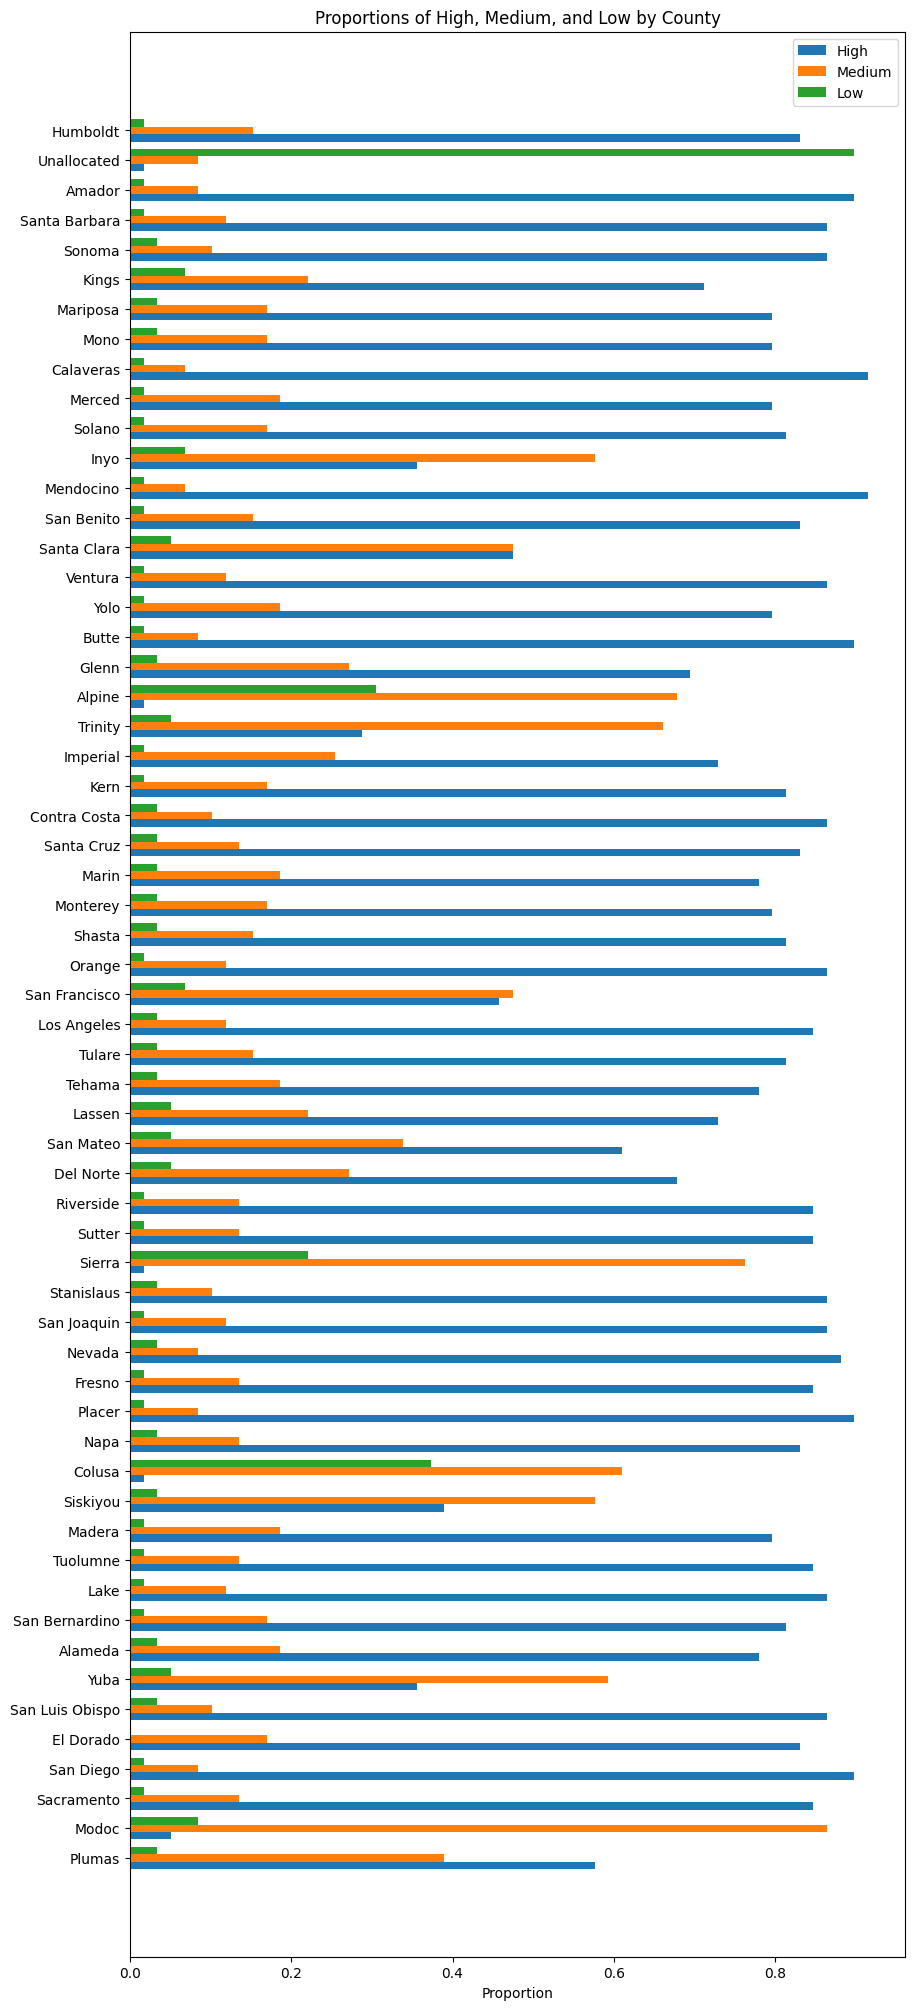

In [15]:
fig, ax = plt.subplots(figsize=(10, 25))
counties = class_cor_df.index
n_counties = len(counties)
ind = np.arange(n_counties)

width = 0.25

bars1 = ax.barh(ind, class_cor_df['high'], width, label='High')
bars2 = ax.barh(ind + width, class_cor_df['med'], width, label='Medium')
bars3 = ax.barh(ind + 2*width, class_cor_df['low'], width, label='Low')

ax.set_xlabel('Proportion')
ax.set_title('Proportions of High, Medium, and Low by County')
ax.set_yticks(ind + width)
ax.set_yticklabels(counties)
ax.legend()

plt.show()

Though not a perfect picture by any means, we can see a general trend of many high correlations between each county. This means that increases/decreases across certain counties may depend on each other BUT not definitively. This is the weakest of explanations so far but provides potential insight into the gaps of our testing and how there COULD potentially be non-inpendence of counties against each other.

We then can observe the data collection method. Here, we don't see much on the data collection process. However, we found this data from a government source, which tend to have a sound reputation for following sampling protocols. We can from this, assume that people were sampled independently in each county for developing the median income metric.  

### Assumption 2: Normality of Differences Between Groups

We need to check that the differences between each group are normally distributed. We will use a QQ-plot and Shapiro-Wilkes Test to check this assumption formally.

In [16]:
diff_df = pct_change_df.diff(axis=1).stack().reset_index(name='difference')
diff_df.head()

,level_0,level_1,difference
0,Plumas,1997,0.041893
1,Plumas,1998,-0.104357
2,Plumas,1999,0.063824
3,Plumas,2000,-0.004677
4,Plumas,2001,-0.057322


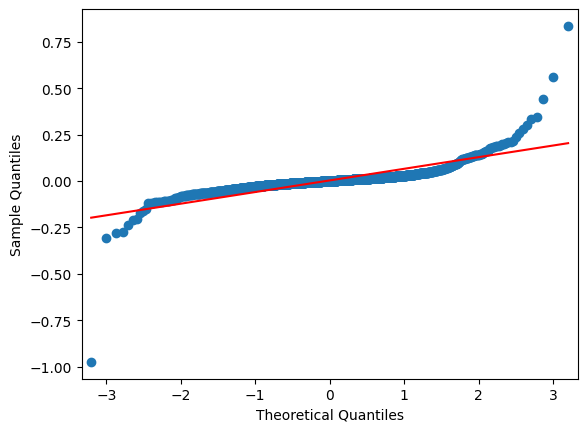

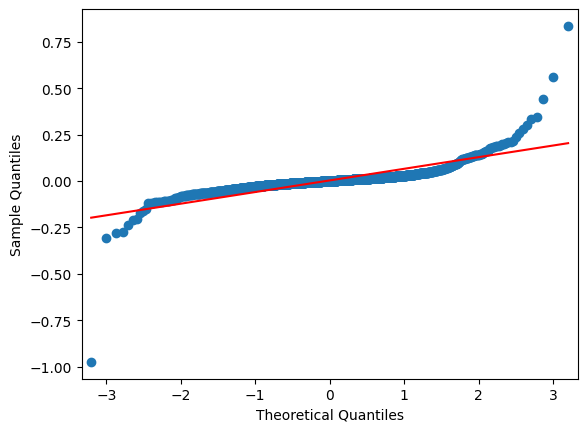

In [17]:
sm.qqplot(diff_df["difference"], line="s")

From a simple raw observation, we can see that these differences differ from the theoretical normal distribution quite significantly. Therefore, we will probably find with the Shapiro-Wilke's test that these difference vary significantly from normal distribution behavior.

$H_0$: The differences between the years of each county is normally distributed <br>
$H_1$: The differences between the years of each county is not normally distributed

In [18]:
wilkes_stat, wilkes_pval = stats.shapiro(diff_df["difference"])
wilkes_pval

0.0

We reject $H_0$ at $\alpha = 0.01$, which means we have sufficient evidence that the differences between the years of each county are not normally distributed. This is directly in line with our beliefs that this data was not normally distributed from the QQ-plot analysis. Fortunately, though assumptions of normality are violated, we can shift to another test called the Permutations Test for RM-ANOVA. This allows us to drop the normality assumptions along with the homogeneity of variances assumption and still come to a strong conclusion. 

## Pivoting: Permutation Test for RM-ANOVA

With the above assumptions being dropped, we can perform the permutation test.

$H_0:$ There is no affect of the county on the increase/decrease percentage of median income. <br>
$H_1:$ There is a significant affect of the county on the increase/decrease percentage of median income.

In [19]:
pct_long = pct_change_df.reset_index().melt(
    id_vars=['index'], var_name='Year', value_name='income_increase'
)
pct_long.rename({'index': 'County'}, inplace=True, axis=1)

In [20]:
def perm_test_rm_anova(data, n_permutations=1000):
    f_stat_original, _ = stats.f_oneway(*[data[col] for col in data.columns])
    
    f_stats = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        permuted_data = data.apply(np.random.permutation, axis=0)
        f_stat_perm, _ = stats.f_oneway(*[permuted_data[col] for col in permuted_data.columns])
        f_stats[i] = f_stat_perm
    
    p_value = np.sum(f_stats >= f_stat_original) / n_permutations
    
    return f_stat_original, p_value

f_stat, p_value = perm_test_rm_anova(pct_change_df)

In [21]:
p_value

0.851

We fail to reject $H_0$, meaning there is a lack of evidence suggesting that there many be an affect on the percentage of median income increase/decrease by the county variable. Here, we have concluded that counties in fact do not deviate significantly in percentage increase/decrease in median income from year-to-year.

# Part 2: Building a Linear Model to Predict Median Income Increase/Decrease